In [211]:
from dotenv import load_dotenv
from google.cloud import bigquery
import os

import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib

In [212]:
if os.environ.get("ENV", "local") == "local":
    load_dotenv()

In [213]:
client = bigquery.Client.from_service_account_json(r'C:\Users\willb\Documents\Projetos\Projeto-Fiap-3\fiap-3-98eeb2f3a5d2.json')

In [859]:
query = """
        SELECT DISTINCT * 
        FROM `fiap-3.fut.dados_modelo_prev`
    """

In [882]:
df = client.query(query).to_dataframe().fillna(0)


c:\Users\willb\Documents\Projetos\Projeto-Fiap-3\venv_fiap3\lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [883]:
df.head()

,id_partida,team_id,opponent_id,rodada,result,contextual_home_score_team,avg_total_goals_team,avg_total_shots_team,avg_shots_on_goal_team,avg_possession_team,avg_expected_goals_team,contextual_home_score_opp,elo_diff,avg_total_goals_opp,avg_total_shots_opp,avg_shots_on_goal_opp,avg_possession_opp,avg_expected_goals_opp,form_score_weighted_team,form_score_weighted_opp
0,1035482,40,62,30,2,0.800000,2.4,23.0,7.4,0.604,2.748,0.071429,-8.0,1.0,8.6,3.6,0.264,0.908,7.4,1.8
1,1035407,40,44,24,2,0.818182,3.0,21.0,9.2,0.600,2.754,0.181818,-7.0,1.2,10.2,3.8,0.348,1.266,6.0,1.6
2,1035500,50,1359,32,2,0.687500,2.4,18.4,6.8,0.670,2.256,0.125000,-7.0,1.4,9.8,4.2,0.458,0.992,7.0,3.4
3,1035128,42,62,10,2,0.600000,2.0,13.2,4.6,0.570,1.572,0.000000,-6.0,0.6,9.8,3.2,0.396,0.932,6.2,0.0
4,1035344,66,62,18,1,1.000000,1.6,14.6,4.6,0.506,1.362,0.000000,-6.0,0.4,7.4,2.2,0.336,0.666,8.2,2.4


In [884]:
target = "result"


features = ['contextual_home_score_team',
             'avg_total_goals_team',
       'avg_total_shots_team',
         'avg_shots_on_goal_team',
          'avg_possession_team',
       'avg_expected_goals_team',
         'contextual_home_score_opp',
           'elo_diff',
       'avg_total_goals_opp',
         'avg_total_shots_opp',
           'avg_shots_on_goal_opp',
       'avg_possession_opp',
         'avg_expected_goals_opp',
       'form_score_weighted_team',
         'form_score_weighted_opp']


In [885]:
features

# Aplica normalização
scaler = StandardScaler()
df_normalized = df.copy()
df_normalized[features] = scaler.fit_transform(df[features])

In [886]:
X = df_normalized[features]
y = df_normalized[target]

In [887]:
# 🔹 4. Separar tipos de colunas
cat_features = ['contexto_jogo'] #, 'formation', 'coach'
num_features = [col for col in features if col not in cat_features]


In [888]:
# 🔹 7. Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [889]:
classes = np.array([0, 1, 2])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [890]:
# Pipeline com SMOTE antes do classificador
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('classifier', RandomForestClassifier(random_state=42, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200, class_weight= class_weights ))
])

In [891]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight={np.int64(0): np.float64(0.8469241773962805),
                                                      np.int64(1): np.float64(1.566137566137566),
                                                      np.int64(2): np.float64(0.8469241773962805)},
                                        n_estimators=200, random_state=42))])

In [892]:

#Grid de hiperparâmetros
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
   'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

In [893]:
# GridSearch com 5 folds, usando treino (com SMOTE)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)


In [894]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(k_neighbors=3, random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(class_weight={np.int64(0): np.float64(0.8469241773962805),
                                                                             np.int64(1): np.float64(1.566137566137566),
                                                                             np.int64(2): np.float64(0.8469241773962805)},
                                                               n_estimators=200,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, None],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [895]:
print("Melhores parâmetros:", grid_search.best_params_)


Melhores parâmetros: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [896]:
y_test

640    2
149    2
245    0
135    2
587    1
      ..
465    0
366    0
308    2
568    0
621    0
Name: result, Length: 148, dtype: Int64

In [897]:
# Avaliar no teste real (sem SMOTE)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       0.52      0.59      0.55        58
         1.0       0.15      0.12      0.14        32
         2.0       0.53      0.52      0.52        58

    accuracy                           0.46       148
   macro avg       0.40      0.41      0.40       148
weighted avg       0.44      0.46      0.45       148

Log Loss: 1.0819524033789933


In [898]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)

In [899]:
# Criar DataFrame para análise detalhada
probs_df = pd.DataFrame(y_prob, columns=pipeline.classes_)
results_df = pd.DataFrame({
    'true_label': y_test.reset_index(drop=True),
    'predicted_label': y_pred,
})

# Concatenar as probabilidades com as classes verdadeiras e previstas
final_df = pd.concat([results_df, probs_df, df_normalized], axis=1)

# Mostrar as primeiras linhas
print("\nExemplo de probabilidades previstas e valores reais:\n")
print(final_df.head(10))


Exemplo de probabilidades previstas e valores reais:

   true_label  predicted_label    0.0    1.0    2.0  id_partida  team_id  \
0           2              0.0  0.465  0.370  0.165     1035482       40   
1           2              2.0  0.225  0.260  0.515     1035407       40   
2           0              1.0  0.315  0.415  0.270     1035500       50   
3           2              2.0  0.190  0.365  0.445     1035128       42   
4           1              0.0  0.570  0.285  0.145     1035344       66   
5           1              2.0  0.245  0.355  0.400     1035358       40   
6           2              2.0  0.125  0.130  0.745     1035364       66   
7           2              2.0  0.220  0.345  0.435     1035442       42   
8           2              2.0  0.310  0.280  0.410     1035475       42   
9           1              0.0  0.635  0.230  0.135     1035486       50   

   opponent_id  rodada  result  ...  avg_expected_goals_team  \
0           62      30       2  ...         

In [905]:
final_df.columns

Index([                'true_label',            'predicted_label',
                                0.0,                          1.0,
                                2.0,                 'id_partida',
                          'team_id',                'opponent_id',
                           'rodada',                     'result',
       'contextual_home_score_team',       'avg_total_goals_team',
             'avg_total_shots_team',     'avg_shots_on_goal_team',
              'avg_possession_team',    'avg_expected_goals_team',
        'contextual_home_score_opp',                   'elo_diff',
              'avg_total_goals_opp',        'avg_total_shots_opp',
            'avg_shots_on_goal_opp',         'avg_possession_opp',
           'avg_expected_goals_opp',   'form_score_weighted_team',
          'form_score_weighted_opp'],
      dtype='object')

In [906]:
final_df[final_df['predicted_label'] == 0]

,true_label,predicted_label,0.0,1.0,2.0,id_partida,team_id,opponent_id,rodada,result,...,avg_expected_goals_team,contextual_home_score_opp,elo_diff,avg_total_goals_opp,avg_total_shots_opp,avg_shots_on_goal_opp,avg_possession_opp,avg_expected_goals_opp,form_score_weighted_team,form_score_weighted_opp
0,2,0.0,0.465,0.370,0.165,1035482,40,62,30,2,...,2.302168,-1.177949,-3.120391,-0.830259,-1.477091,-0.833356,-2.298346,-1.303395,1.467219,-0.767804
4,1,0.0,0.570,0.285,0.145,1035344,66,62,18,1,...,-0.413762,-1.443298,-2.340294,-1.630828,-1.818225,-1.713779,-1.598838,-1.777605,1.786508,-0.528337
9,1,0.0,0.635,0.230,0.135,1035486,50,52,31,2,...,1.232256,-0.381902,-2.340294,-0.563403,-0.908533,-1.084905,-0.588437,-0.405924,0.988286,-0.687981
12,2,0.0,0.540,0.405,0.055,1035552,50,48,38,2,...,1.471320,0.001379,-2.340294,-0.296547,-0.112553,-0.204483,-0.685591,-0.358895,2.105797,-0.049403
17,0,0.0,0.420,0.355,0.225,1035369,50,62,19,2,...,0.460195,-1.443298,-1.950245,-1.097115,-1.249668,-1.336455,-1.773715,-0.993787,0.828641,-0.687981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0,0.0,0.515,0.210,0.275,1035315,51,55,15,2,...,-0.695936,-0.205003,-0.780098,-0.029691,0.342293,-0.456032,-0.258114,0.887376,-0.049403,0.429530
142,0,0.0,0.755,0.125,0.120,1035316,34,45,15,0,...,0.279917,-0.912600,-0.780098,-0.563403,-0.283120,-0.456032,-1.404530,-0.652826,1.227752,0.828641
143,0,0.0,0.445,0.210,0.345,1035334,35,1359,28,2,...,0.624797,-0.871777,-0.780098,-0.563403,0.399149,-0.707581,0.383101,-0.249160,0.030419,-1.087093
146,0,0.0,0.460,0.255,0.285,1035348,34,1359,18,0,...,1.475240,-0.978937,-0.780098,-0.296547,-1.931937,-1.336455,-1.501684,-2.134243,0.429530,-1.007270


<Figure size 600x500 with 0 Axes>

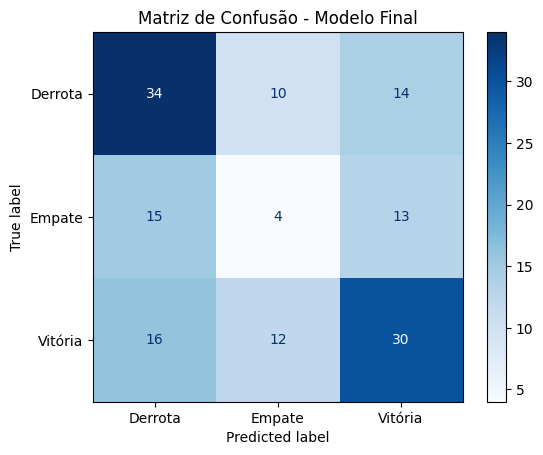

In [909]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Se estiver usando mapeamento -1 → 0, etc., reverta aqui:
inv_map = {0: -1, 1: 0, 2: 1}
y_test_original = y_test.map(inv_map)
y_pred_original = pd.Series(y_pred).map(inv_map)

# Matriz de confusão
cm = confusion_matrix(y_test_original, y_pred_original, labels=[-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Derrota', 'Empate', 'Vitória'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Modelo Final')
plt.show()

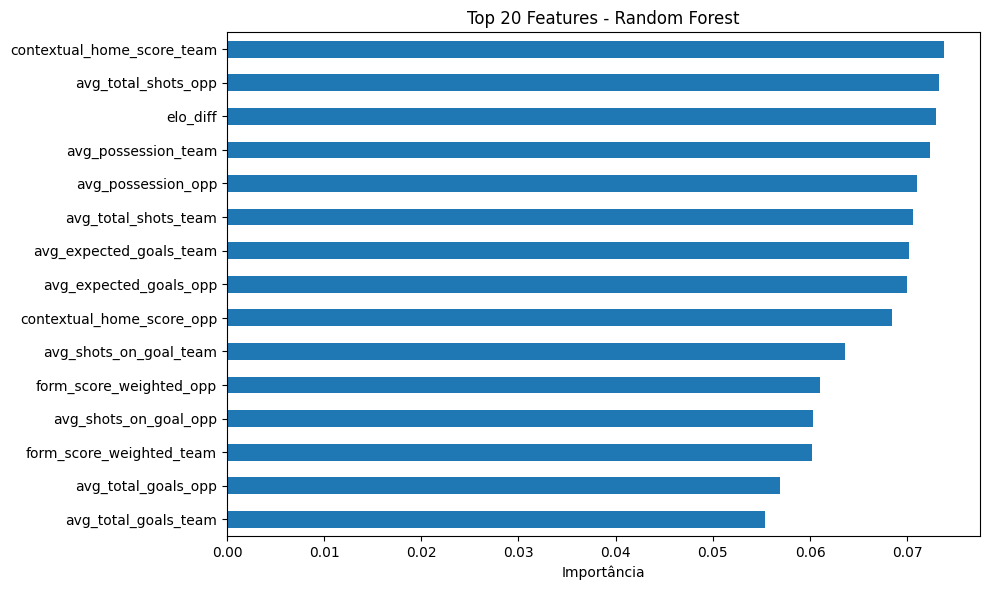

In [903]:
import pandas as pd
import matplotlib.pyplot as plt

# Acessando o modelo Random Forest dentro do pipeline
rf_model = pipeline.named_steps['classifier']

# Acessando os nomes das features após o preprocessor
feature_names = (X.columns)

# Extraindo a importância das features
importances = rf_model.feature_importances_

# Criando gráfico
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Top 20 Features - Random Forest')
plt.gca().invert_yaxis()
plt.xlabel('Importância')
plt.tight_layout()
plt.show()


In [910]:
joblib.dump(pipeline, 'modelo_random_forest_dupla_entrada.pkl')

['modelo_random_forest_dupla_entrada.pkl']